In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score
import dask_ml
import dask
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Sending large graph.*")

from dask.distributed import Client, LocalCluster
import dask.multiprocessing

cluster = LocalCluster(processes=True,n_workers=6, threads_per_worker=1)
client = Client(cluster)
import sys
import pickle 

from data_helpers import *
from metrics import *

In [2]:
folders = [
    'train0_25',
    'train25_50',
    'train50_75',
    'train75_100'
]

# Read Parquet files from each folder into Dask DataFrames
dfs = [dd.read_parquet(folder) for folder in folders]

# Concatenate all DataFrames into a single DataFrame
data = dd.concat(dfs)

In [3]:
np.random.seed(42)

orig_partitions = [i for i in range(0,int(data.npartitions))]
np.random.shuffle(orig_partitions) #shuffles inplace

trainSep = int(0.7* data.npartitions)
valEnd = data.npartitions #int(0.05* data.npartitions) + trainSep

sampledPartIdxTrain = orig_partitions[0:trainSep]
sampledPartIdxTest  = orig_partitions[trainSep:valEnd]

In [4]:
with open('meanDict_allT.pkl', 'rb') as f:
    meanDict = pickle.load(f)

with open('stdDict_allT.pkl', 'rb') as f:
    stdDict = pickle.load(f)

with open('minVal_allT2.pkl', 'rb') as f:
    minDict = pickle.load(f)

with open('zScore_allT2.pkl', 'rb') as f:
    zscoreDict = pickle.load(f)

In [5]:
baseTrain = data.partitions[sampledPartIdxTrain[0:15]].compute()
largeV_26 = pd.read_csv('large_ptend_q0002_26_allData.csv')
largeV = pd.read_parquet('large_training_df_0001')

2024-07-08 14:59:36,411 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9b105c402b95a79c04601470c1d68931', 0): 'waiting'}
2024-07-08 14:59:37,655 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9b105c402b95a79c04601470c1d68931', 0): 'waiting'}
2024-07-08 14:59:39,357 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9b105c402b95a79c04601470c1d68931', 0): 'waiting'}
2024-07-08 14:59:40,803 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9b105c402b95a79c04601470c1d68931', 0): 'waiting'}
2024-07-08 14:59:42,312 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9b105c402b95a79c04601470c1d68931', 0): 'waiting'}
2024-07-08 14:59:43,701 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9b105c402b95a79c04601470c1d68931', 0): 'waiting'}
2024-07-08 14:59:44,956 - distributed.scheduler - ERROR - Couldn't gather keys: {('repar

In [6]:
val = data.partitions[sampledPartIdxTest[15:30]].compute()

2024-07-08 14:59:51,758 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-3cc889173eb2b6c1a54f96137157e1ac', 0): 'waiting'}
2024-07-08 14:59:53,820 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-3cc889173eb2b6c1a54f96137157e1ac', 0): 'waiting'}
2024-07-08 14:59:56,107 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-3cc889173eb2b6c1a54f96137157e1ac', 0): 'waiting'}
2024-07-08 14:59:58,280 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-3cc889173eb2b6c1a54f96137157e1ac', 0): 'waiting'}


In [47]:
"""
custom log function to map into a continuous region, gives more resolution to the small values
"""
def custom_log_2(x, minValue, offset=6, nullValFactor=1):  #offset of works for [-403:403] of x values otherwise sign is lost
    nullValueFeat = -minValue*nullValFactor             # define the 0-value in the feature space
    x[x==0] = nullValueFeat                             # will make problems bc 0 could be positive but also negative! dynamics will point in different directions
    y = np.log(abs(x))
    y = y - offset                                      #move curve down such that we have a bigger domain that always has negative values as an outcome [-403:403]
    nullValueLog = np.log(abs(nullValueFeat)) - offset  # transform 0-value into log space
    y[x>0] = nullValueLog - (y[x>0] - nullValueLog)
    print(nullValueLog,nullValueFeat)
    y = y - nullValueLog
    return y


def inv_custom_log_2(y,minDict, offset=6, nullValFactor=1):
    nullValueFeat = -minDict['min']*nullValFactor
    nullValueLog  = np.log(abs(nullValueFeat)) - offset 

    #print(nullValueLog,nullValueFeat)
    x = y.copy()
    x = x + nullValueLog
    x[y<nullValueLog] = nullValueLog - (x[y<nullValueLog] - nullValueLog) # remap to log function
    #print('mirror values',x)
    x = x + offset                                                        # add offset
    x = np.exp(x)                                                         # apply exp funciton (all pos values aftewards)
    #print('exp values',x)
    x[x<nullValueFeat] = 0                                                # map to 0
    x[y>nullValueLog] = -x[y>nullValueLog]                                # find negative values

    # clip to physical values
    x = np.clip(x, minDict['maxNeg'], minDict['maxPos'])
    return x

In [23]:
minValue

3.901450281741167e-42

In [24]:
train[transfF] = custom_log_2(train[f].copy(), minValue=4e-23)
val[transfF] = custom_log_2(val[f].copy(), minValue=4e-23)

-57.57316277774316 -4e-23
-57.57316277774316 -4e-23


In [16]:
abs(train.loc[train[f] != 0][f]).sort_values(), f

(3346    3.062462e-23
 3345    3.062462e-23
 3494    3.276552e-23
 1120    2.611583e-22
 431     3.250200e-22
             ...     
 31      1.243012e-07
 3435    1.269117e-07
 502     1.362616e-07
 3446    1.404723e-07
 2215    1.656795e-07
 Name: ptend_q0002_55, Length: 137366, dtype: float64,
 'ptend_q0002_55')

In [120]:
f2 = 'ptend_t_1'
datafeat2 = data['ptend_t_1'].compute()

In [17]:
abs(data.loc[data[f] != 0][f]).min().compute() 
# more smaller values in data that are not in training! 
# need to find a dataset with small and large values -> the extremes

3.901450281741167e-42

In [115]:
dataFeat = data[f].compute()

KeyboardInterrupt: 

In [22]:
dataFeat.loc[(dataFeat !=0) & (abs(dataFeat)<1e-24)]

1702   -9.823808e-25
1704   -9.823808e-25
516    -2.966202e-38
1868   -9.659105e-27
406    -3.912963e-34
2825   -4.557658e-26
1926   -3.037458e-26
1927   -3.037458e-26
371    -8.129479e-27
85     -2.533443e-28
1101   -3.296424e-26
1103   -3.296424e-26
2046   -2.561276e-25
2723   -1.586455e-25
416    -7.711782e-25
1410   -1.785482e-26
3424   -1.483786e-28
2008   -1.460343e-25
287    -1.980850e-25
671    -1.387983e-27
2587   -5.197193e-28
1918   -5.147486e-26
2963   -8.175884e-27
2964   -8.175884e-27
3117   -4.023105e-25
1295   -1.042662e-27
1553   -1.882060e-26
2875   -2.208642e-28
1878   -3.901450e-42
2127   -3.352719e-26
2129   -3.352719e-26
Name: ptend_q0002_55, dtype: float64

In [42]:
res

(array([1.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 3.000000e+00,
        7.000000e+00, 1.600000e+01, 9.600000e+01, 4.300000e+02,
        5.680000e+02, 1.520000e+03, 4.862000e+03, 1.700600e+04,
        8.762800e+04, 8.068050e+05, 6.337524e+06, 2.274766e+06]),
 array([-95.34722555, -91.35610941, -87.36499326, -83.37387711,
        -79.38276097, -75.39164482, -71.40052867, -67.40941252,
        -63.41829638, -59.42718023, -55.43606408, -51.44494794,
        -47.45383179, -43.46271564, -39.47159949, -35.48048335,
        -31.4893672 , -27.49825105, -23.5071349 , -19.51601876,
        -15.52490261]),
 <BarContainer object of 20 artists>)

[Text(-27.274280958291794, 0, '1.428664594034974e-12'),
 Text(-26.10240640372517, 0, '4.6117837474518674e-12'),
 Text(-24.930531849158548, 0, '1.4887013664412585e-11'),
 Text(-23.758657294591924, 0, '4.805584736423526e-11'),
 Text(-22.5867827400253, 0, '1.5512610641415703e-10'),
 Text(-21.41490818545868, 0, '5.007529824377957e-10'),
 Text(-20.243033630892054, 0, '1.6164497080258316e-09'),
 Text(-19.07115907632543, 0, '5.217961250787708e-09'),
 Text(-17.89928452175881, 0, '1.6843777742998505e-08'),
 Text(-16.727409967192187, 0, '5.4372356370546494e-08'),
 Text(-15.555535412625563, 0, '1.7551603817110404e-07'),
 Text(-14.383660858058938, 0, '5.665724590881994e-07'),
 Text(-13.211786303492316, 0, '1.8289174866419537e-06'),
 Text(-12.039911748925693, 0, '5.903815336043377e-06'),
 Text(-10.868037194359069, 0, '1.9057740864022146e-05'),
 Text(-9.696162639792448, 0, '6.151911368617201e-05'),
 Text(-8.524288085225823, 0, '0.00019858604310634054'),
 Text(-7.352413530659199, 0, '0.00064104331407

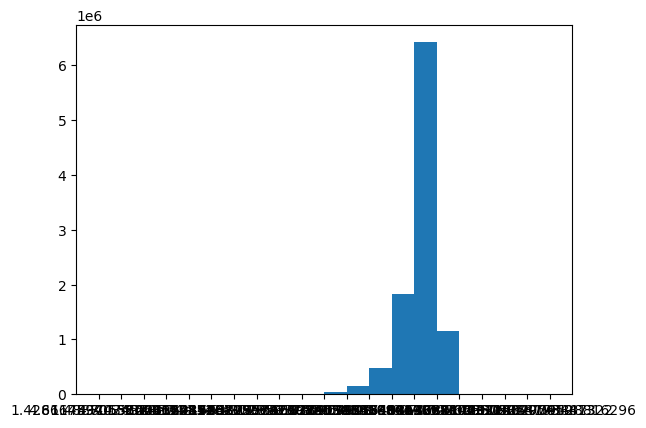

In [67]:
fig, ax = plt.subplots()
res = ax.hist(np.log(abs(datafeat2.loc[datafeat2!=0])), bins=20)

valArr = res[1]
ax.set_xticks(valArr)
ax.set_xticklabels(np.exp(valArr))

# maybe log transform is not the best since it makes the space between 0 and the next small values so large -> rescaling might be better

# for q0002_26 extreme values are sparse -> log transform works perfectly
# for q0002_55 tiny values are sparse -> uninteresting

In [43]:
zscoreDict

{'ptend_t_0': {'min': -63.21447975879488, 'max': 245.67247936945668},
 'ptend_t_1': {'min': -85.03918460626298, 'max': 485.3715638134578},
 'ptend_t_2': {'min': -126.60629741789786, 'max': 68.02051460930264},
 'ptend_t_3': {'min': -63.63672121888045, 'max': 2.8775431157252003},
 'ptend_t_4': {'min': -3.6853286303219415, 'max': 2.1461468624645654},
 'ptend_t_5': {'min': -2.5782653965224633, 'max': 2.294037629450322},
 'ptend_t_6': {'min': -2.0357513955629463, 'max': 2.657069630332726},
 'ptend_t_7': {'min': -2.546213690396981, 'max': 2.971244695190985},
 'ptend_t_8': {'min': -2.530318347897266, 'max': 3.1563311665414484},
 'ptend_t_9': {'min': -2.450968150453563, 'max': 3.372380426837497},
 'ptend_t_10': {'min': -2.5501623751607663, 'max': 3.3834928657381136},
 'ptend_t_11': {'min': -2.5926513754892664, 'max': 3.3065237327024843},
 'ptend_t_12': {'min': -2.620270894761342, 'max': 3.3768677441385972},
 'ptend_t_13': {'min': -2.971609148196438, 'max': 3.2113149540255908},
 'ptend_t_14': {

# find dimensions in data

In [117]:
minDimNeg = abs(datafeat2.loc[datafeat2 < 0]).min()
minDimPos = abs(datafeat2.loc[datafeat2 > 0]).min() 
maxDimNeg = abs(datafeat2.loc[datafeat2 < 0]).max()
maxDimPos = abs(datafeat2.loc[datafeat2 > 0]).max() 

minDimNeg, minDimPos, maxDimNeg, maxDimPos

(3.3536906585140966e-11,
 1.428664594034975e-12,
 0.0037861388946562,
 0.0215627095288163)

In [187]:
""" calc normalized weight of histogram distribution """
def calcNormWeightLogDist(datafeat2,binsPos=10, binsNeg=10):
    resNeg = np.histogram(np.log(abs(datafeat2.loc[datafeat2 < 0])), bins = binsNeg)
    resPos = np.histogram(np.log(abs(datafeat2.loc[datafeat2 > 0])), bins = binsPos)
    nZero  = datafeat2.loc[datafeat2 == 0].shape[0]

    counts, bins = resPos
    nBinsP = len(resPos[1])
    nBinsN = len(resNeg[1])
    overallBins = np.zeros((nBinsP+1+nBinsN))
    overallBins[0:nBinsN] = np.sort(-np.exp(resNeg[1]))
    overallBins[nBinsN:nBinsN+1] = 0
    overallBins[nBinsN+1:nBinsN+1+nBinsP] = np.exp(resPos[1])

    counts, bins = np.histogram(datafeat2, bins=overallBins)

    def findBin(x,bins):
        foundBin = False
        for i in range(len(bins)-1):

            if x>=bins[i] and x<=bins[i+1]:# and foundBin==False:
                foundBin=True
                relevantBin = bins[i]
                break
            # if rounding errors occure
            if foundBin == False and i == len(bins)-2:
                isBinCloseToTopEdge = x>=bins[i] and x<=bins[i+1]*1.1
                isBinCloseToBottomEdge = x>=bins[0]*0.9 and x<=bins[1]
                if isBinCloseToTopEdge:
                    relevantBin = bins[i]
                    foundBin=True
                if isBinCloseToBottomEdge:
                    relevantBin = bins[0]
                    foundBin=True
        if foundBin == False:
            print('didnt find bin, something is wrong!',x)
            return 0
        else:
            return relevantBin


    df = pd.DataFrame(datafeat2, columns=[f2])
    df['bins'] = df[f2].apply(lambda x: findBin(x,bins))

    valueCountsDict = df['bins'].value_counts()
    df['weightBins'] = df['bins'].apply(lambda x: valueCountsDict[x])

    df['normWeightBins'] = 1/df['weightBins']
    df['normWeightBins'] = df['normWeightBins'] / df.normWeightBins.unique().sum() # weights sum to 1
    return df

In [189]:
f2 = 'ptend_q0001_17'
datafeat2 = data[f2].compute()
df_q0001_17 = calcNormWeightLogDist(datafeat2)

In [193]:
df_q0001_17.groupby('weightBins').mean()

,ptend_q0001_17,bins,normWeightBins
weightBins,,,
188,0.000000e+00,-1.764652e-25,0.678555
1487,8.684937e-10,3.534100e-10,0.085789
1537,-6.250576e-10,-1.222821e-08,0.082998
4133,-5.166573e-21,-1.990078e-20,0.030866
5860,6.357004e-21,4.436281e-22,0.021769
7438,-4.154738e-24,-8.525688e-24,0.017151
7627,4.305617e-24,1.764652e-25,0.016726
8534,-3.045453e-19,-9.614807e-19,0.014948
8850,-5.458689e-23,-4.119076e-22,0.014414


TODO: define weighting base on:
- how many samples are in the respective dimension: build histogram over pos & negative samples + 0 -> equally weight all of them
- z score of samples -> the larger the more important

# test weighted lgbm

In [64]:
f = 'ptend_q0001_17'

filtered = largeV.loc[abs(largeV[f]) >= abs(meanDict[f])]
filtered = largeV.loc[(largeV[f] >= (meanDict[f] + 20*stdDict[f])) | (largeV[f] <= (meanDict[f] - 20*stdDict[f]))]
print(filtered.shape, largeV.shape)
#train = pd.concat([baseTrain,largeV_f], axis = 0)
#train = pd.concat([baseTrain,largeV_26], axis = 0)
train = pd.concat([baseTrain,filtered], axis = 0)
#train = pd.concat([baseTrain,largeV], axis = 0)

valSet = lgb.Dataset(val[allF], label=val[f], free_raw_data=False)
weight = (((train[f] - meanDict[f])/stdDict[f])**2)#specific weighting based on feature
weight = abs(((train[f] - meanDict[f])/stdDict[f]))
#weight = weight / min(weight)
trainSet = lgb.Dataset(train[allF], train[f], weight=train['weight'], free_raw_data=False)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    #'num_leaves': 15,
    #'learning_rate': 0.05,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': 1
}


gbm = None

gbm = lgb.train(params,
            trainSet,
            num_boost_round=500, 
            valid_sets=valSet,
            init_model=gbm)

predTrain = gbm.predict(train[allF])
predVal = gbm.predict(val[allF])
r2train =r2_score(train[f], predTrain)
r2test =r2_score(val[f], predVal)
print('r2 scores', r2train,r2test)# 'transormed',r2_score(train[transfF], predTrain0),r2_score(val[transfF], predVal0))

(917, 927) (90485, 927)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112351
[LightGBM] [Info] Number of data points in the train set: 54232, number of used features: 481
[LightGBM] [Info] Start training from score 0.000000
r2 scores 0.9233775438640869 -149.81942687502914


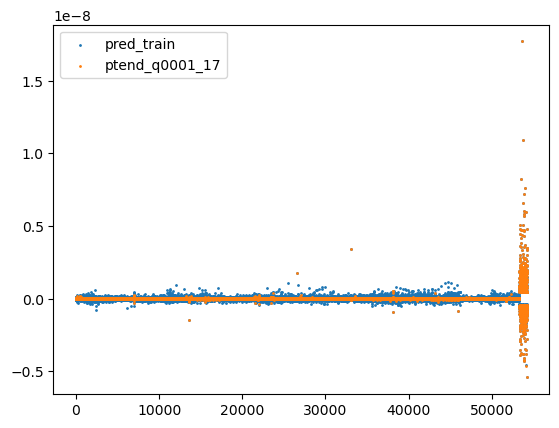

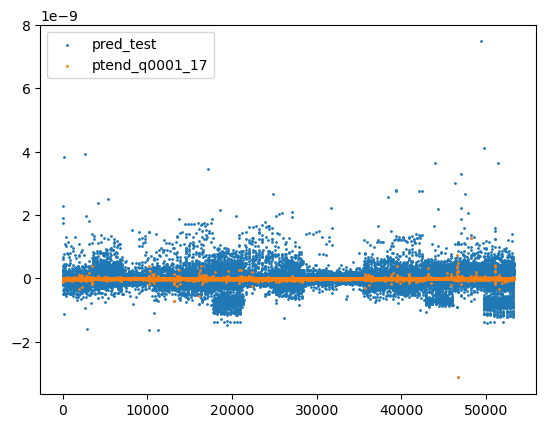

In [65]:
""" in feature space """
plt.scatter(x=range(train.shape[0]),y=predTrain, s=1,label='pred_train')
plt.scatter(x=range(train.shape[0]),y=train[f], s=1,label=f)
plt.legend()
plt.show()

plt.scatter(x=range(val.shape[0]),y=predVal, s=1,label='pred_test')
plt.scatter(x=range(val.shape[0]),y=val[f], s=1,label=f)

plt.legend()
plt.show()

# test transformed lgbm

In [48]:
f = 'ptend_q0001_17'
minValue = minDict[f]['min']
transfF = f+'_transf'

filtered = largeV.loc[abs(largeV[f]) >= abs(meanDict[f])]
print(filtered.shape, largeV.shape)
#train = pd.concat([baseTrain,largeV_f], axis = 0)
#train = pd.concat([baseTrain,largeV_26], axis = 0)
#train = pd.concat([baseTrain,filtered], axis = 0)
train = pd.concat([baseTrain,largeV], axis = 0)

train[transfF] = custom_log_2(train[f].copy(), minValue=minValue)
val[transfF] = custom_log_2(val[f].copy(), minValue=minValue)

valSet = lgb.Dataset(val[allF], label=val[transfF], free_raw_data=False)
weight = (((train[f] - meanDict[f])/stdDict[f])**2)#specific weighting based on feature
weight = abs(((train[f] - meanDict[f])/stdDict[f]))
weight = weight / min(weight)
trainSet = lgb.Dataset(train[allF], train[transfF], weight=weight)#train['weight'], free_raw_data=False)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    #'num_leaves': 15,
    #'learning_rate': 0.05,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': 1
}


gbm = None

gbm = lgb.train(params,
            trainSet,
            num_boost_round=200, 
            valid_sets=valSet,
            init_model=gbm)

predTrain0 = gbm.predict(train[allF])
predVal0 = gbm.predict(val[allF])
predTrain = inv_custom_log_2(predTrain0, minDict[f])
predVal = inv_custom_log_2(predVal0, minDict[f])
r2train =r2_score(train[f], predTrain)
r2test =r2_score(val[f], predVal)
print('r2 scores', r2train,r2test, 'transormed',r2_score(train[transfF], predTrain0),r2_score(val[transfF], predVal0))

(83904, 927) (90485, 927)
-62.99667383609216 -1.7646519734464592e-25
-62.99667383609216 -1.7646519734464592e-25
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.443678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112697
[LightGBM] [Info] Number of data points in the train set: 143800, number of used features: 484
[LightGBM] [Info] Start training from score 8.133867
r2 scores -8005.958744040207 -417375.2908218601 transormed 0.2995704294230759 0.12041574034510028


In [45]:
predTrain0 = gbm.predict(train[allF])
predVal0 = gbm.predict(val[allF])
predTrain = inv_custom_log_2(predTrain0, minDict[f])
predVal = inv_custom_log_2(predVal0, minDict[f])
r2train =r2_score(train[f], predTrain)
r2test =r2_score(val[f], predVal)
print('r2 scores', r2train,r2test, 'transormed',r2_score(train[transfF], predTrain0),r2_score(val[transfF], predVal0))

r2 scores -8021.410051114805 -417795.5971512 transormed 0.2995704289997715 0.12041574012263812


In [ ]:
train['prediction_log'] = predTrain0
train['prediction_feat'] = predTrain

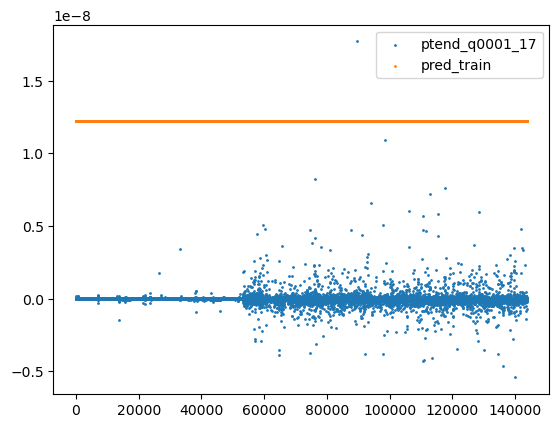

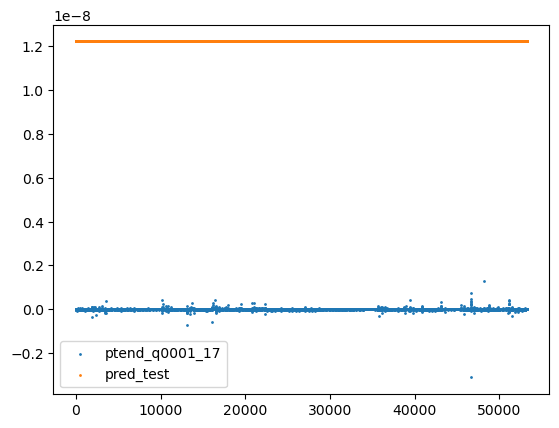

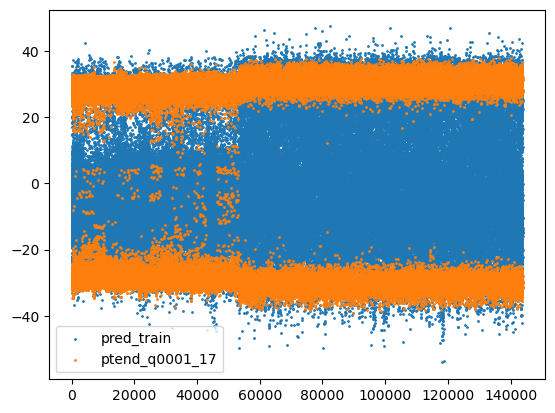

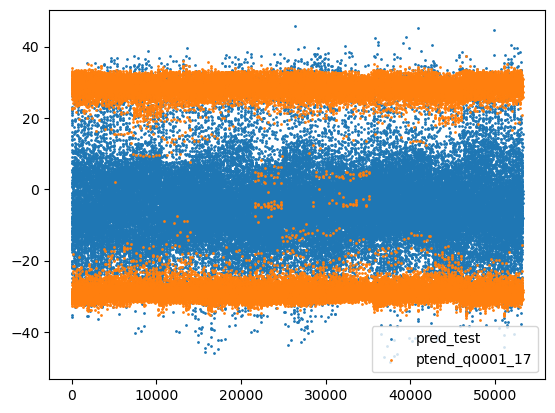

In [49]:
""" in feature space """
plt.scatter(x=range(train.shape[0]),y=train[f], s=1,label=f)
plt.scatter(x=range(train.shape[0]),y=predTrain, s=1,label='pred_train')
plt.legend()
plt.show()

plt.scatter(x=range(val.shape[0]),y=val[f], s=1,label=f)
plt.scatter(x=range(val.shape[0]),y=predVal, s=1,label='pred_test')
plt.legend()
plt.show()

""" in transformed space """
plt.scatter(x=range(train.shape[0]),y=predTrain0, s=1,label='pred_train')
plt.scatter(x=range(train.shape[0]),y=train[transfF], s=1,label=f)
plt.legend()
plt.show()

plt.scatter(x=range(val.shape[0]),y=predVal0, s=1,label='pred_test')
plt.scatter(x=range(val.shape[0]),y=val[transfF], s=1,label=f)
plt.legend()
plt.show()